In [1]:
import sys
sys.path.append("../")

import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import generate
from models.train_utils import create_input_iter, param_count
from datasets import load_data

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import cm
cmap = cm.get_cmap('viridis_r')

import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

import logging
import matplotlib

logging.getLogger('matplotlib').setLevel(logging.ERROR)

/tmp/ipykernel_2627327/764414799.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis_r')
/tmp/ipykernel_2627327/764414799.py:10: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


## Dirs

In [3]:
data_dir = "/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/"

## My new runs
logging_dir = "/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-checkpoints/cosmology/"
run_name = "divine-breeze-139"  # GNN
run_name = "magical-goosebump-109"  # Transformer

## Load cluster run

In [4]:
config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [5]:
# Load the dataset
train_ds, norm_dict = load_data(
        config.data.dataset,
        config.data.n_features,
        config.data.n_particles,
        32,
        config.seed,
        shuffle=True,
        split="test",
        #**config.data.kwargs,
    )

batches = create_input_iter(train_ds)

In [6]:
x, conditioning, mask = next(batches)
x = x.reshape(-1, config.data.n_particles, config.data.n_features)
conditioning = conditioning.reshape(-1, 2)
mask = mask.reshape(-1, config.data.n_particles)

In [7]:
# Diffusion model
x_mean = tuple(map(float, norm_dict["mean"]))
x_std = tuple(map(float, norm_dict["std"]))
config.data.apply_pbcs = False
box_size = config.data.box_size
unit_cell = tuple(map(tuple, config.data.unit_cell)) if config.data.apply_pbcs else None

norm_dict_input = FrozenDict(
    {
        "x_mean": x_mean,
        "x_std": x_std,
        "box_size": box_size,
        "unit_cell": unit_cell,
    }
)

In [8]:
print("{} devices visible".format(jax.device_count()))

# Score and (optional) encoder model configs
score_dict = FrozenDict(config.score)
encoder_dict = FrozenDict(config.encoder)
decoder_dict = FrozenDict(config.decoder)

# Diffusion model
vdm = VariationalDiffusionModel(
        d_feature=config.data.n_features,
        timesteps=config.vdm.timesteps,
        noise_schedule=config.vdm.noise_schedule,
        noise_scale=config.vdm.noise_scale,
        d_t_embedding=config.vdm.d_t_embedding,
        gamma_min=config.vdm.gamma_min,
        gamma_max=config.vdm.gamma_max,
        score=config.score.score,
        score_dict=score_dict,
        embed_context=config.vdm.embed_context,
        d_context_embedding=config.vdm.d_context_embedding,
        n_classes=config.vdm.n_classes,
        use_encdec=config.vdm.use_encdec,
        encoder_dict=encoder_dict,
        decoder_dict=decoder_dict,
        norm_dict=norm_dict_input,
)

# Pass a test batch through to initialize model
x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(42)
_, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])

print(f"Params: {param_count(params):,}")

# Training config and state
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=config.optim.learning_rate, warmup_steps=config.training.warmup_steps, decay_steps=config.training.n_train_steps)
tx = optax.adamw(learning_rate=schedule, weight_decay=config.optim.weight_decay)
if hasattr(config.optim, "grad_clip"):
    if config.optim.grad_clip is not None:
        tx = optax.chain(
            optax.clip(config.optim.grad_clip),
            tx,
        )

state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)

4 devices visible
Params: 4,776,281


In [9]:
ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state, step=295000)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [10]:
x = x * norm_dict['std'] + norm_dict['mean']

## Generate and evaluate simulations

In [11]:
n_samples = 2
idx_rnd = vnp.random.choice(vnp.arange(len(x)), size=n_samples, replace=False)

cond_gen = conditioning[idx_rnd]
mask_gen = mask[idx_rnd]

rng, _ = jax.random.split(rng)

x_samples = generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), conditioning=cond_gen, mask=mask_gen, steps=500)
x_samples = x_samples.mean()

In [12]:
x_samples = x_samples * norm_dict['std'] + norm_dict['mean']

In [13]:
def scale_array(arr, min_val, max_val):

    # Find the minimum and maximum values of the input array
    arr_min = np.min(arr)
    arr_max = np.max(arr)

    # Scale the array
    scaled_arr = (arr - arr_min) / (arr_max - arr_min) * (max_val - min_val) + min_val

    return scaled_arr

# scale_array(np.exp(x_samples[idx, :, 6]), 1., 10.)

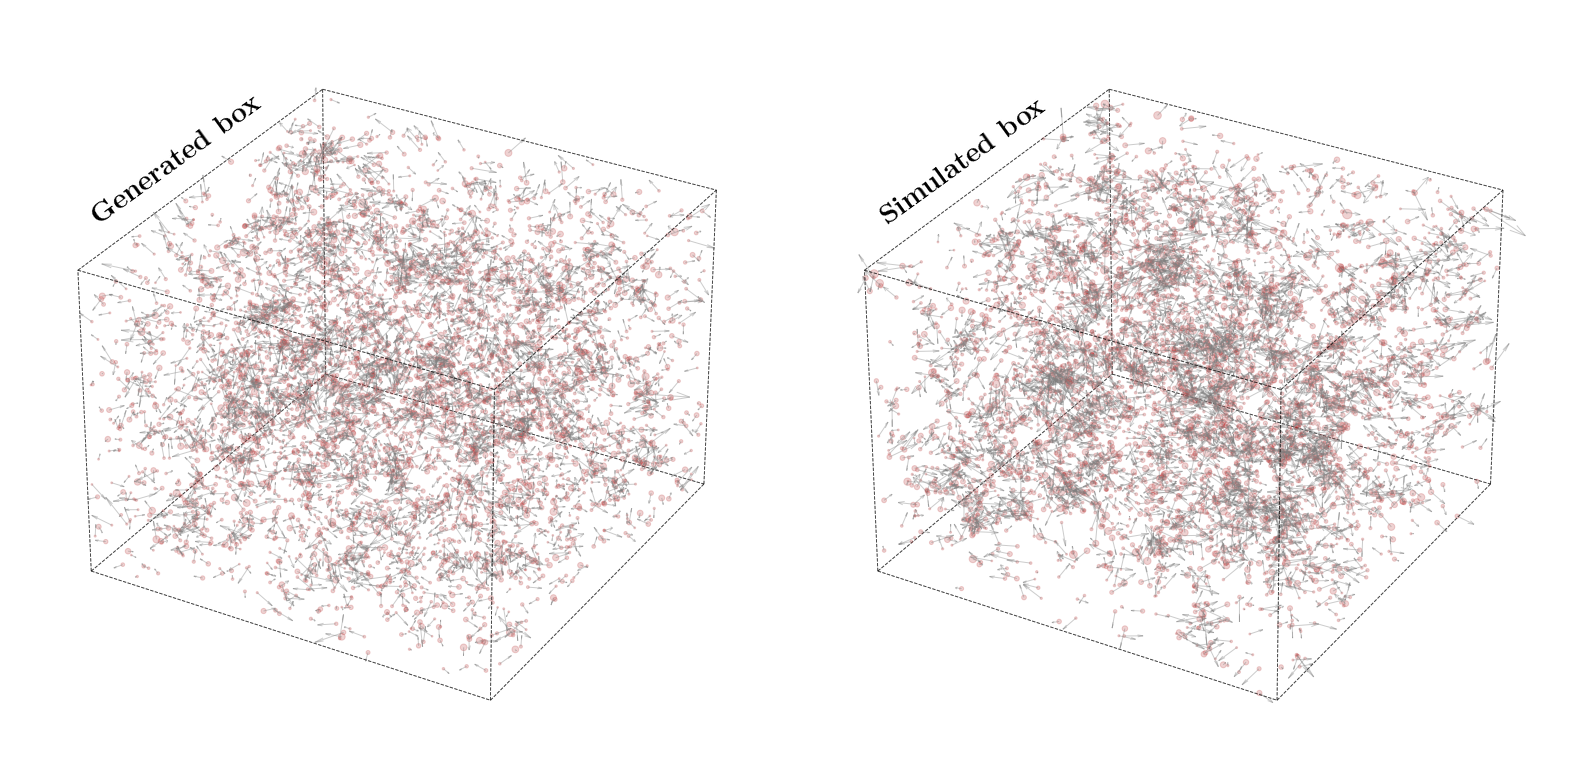

In [17]:
idx = 1
idx_x = idx_rnd[idx]

color = "firebrick"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 11), subplot_kw={'projection':'3d'})

ax1.scatter(x_samples[idx, :, 0], x_samples[idx, :, 1], x_samples[idx, :, 2], 
            alpha=0.2, color=color,
            s=scale_array(np.exp(x_samples[idx, :, 6]), 3., 90.));

ax2.scatter(x[idx_x, :, 0], x[idx_x, :, 1], x[idx_x, :, 2], 
            alpha=0.2, color=color,
            s=scale_array(np.exp(x[idx_x, :, 6]), 3., 90.));

ax1.quiver(x_samples[idx, :, 0], x_samples[idx, :, 1], x_samples[idx, :, 2],
           x_samples[idx, :, 3], x_samples[idx, :, 4], x_samples[idx, :, 5], 
           linewidths=1., length=0.08, color='grey', alpha=0.4, rasterized=False)

ax2.quiver(x[idx_x, :, 0], x[idx_x, :, 1], x[idx_x, :, 2],
           x[idx_x, :, 3], x[idx_x, :, 4], x[idx_x, :, 5], 
           linewidths=1., length=0.08, color='grey', alpha=0.4, rasterized=False)

ax1.set_title(r"\textbf{Generated box}", fontsize=28, rotation=36, y=0.77, x=0.22)
ax2.set_title(r"\textbf{Simulated box}", fontsize=28, rotation=36, y=0.77, x=0.22)

lims = np.array([-20, 1020])

for ax in [ax1, ax2]:
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_zlim(lims)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    ax.set_axis_off()

    box_color = 'k'
    box_ls = '--'
    box_alpha = 0.5
    box_lw = 0.9
    
    r = np.array([0, 1000])
    Z = r
    X, Y = np.meshgrid(r, r)
    
    # Re-creating the 2D arrays for Z component to match the shape of X and Y for the top and bottom surfaces
    Z_bottom = np.zeros_like(X)
    Z_top = np.ones_like(X) * Z[1]
    
    # Bottom surface
    ax.plot_wireframe(X, Y, Z_bottom, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    # Top surface
    ax.plot_wireframe(X, Y, Z_top, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    # Sides
    ax.plot_wireframe(X, np.full_like(X, Z[0]), Y, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    ax.plot_wireframe(X, np.full_like(X, Z[1]), Y, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    ax.plot_wireframe(np.full_like(Y, Z[0]), Y, X, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
    ax.plot_wireframe(np.full_like(Y, Z[1]), Y, X, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)

plt.tight_layout()
plt.savefig("plots/box_vel_viz.pdf", dpi=120)